# Siam-RPN
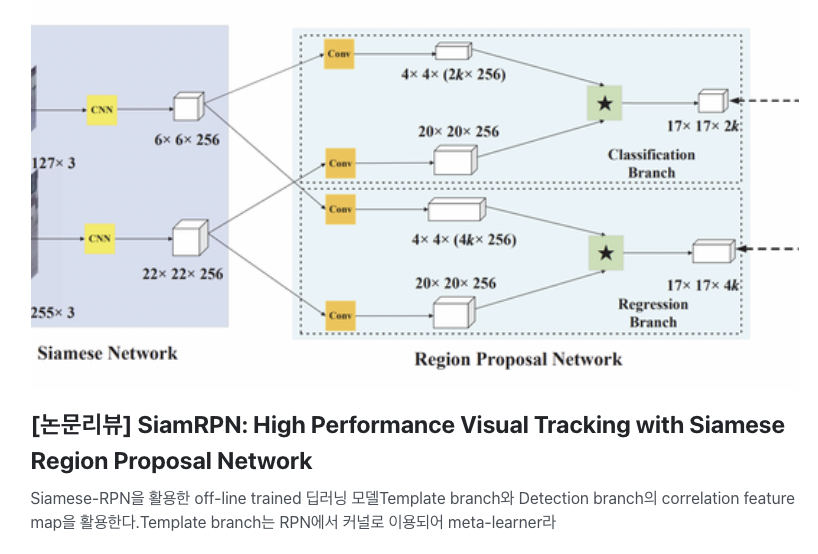
**Blog review**  
https://velog.io/@kimkj38/%EB%85%BC%EB%AC%B8%EB%A6%AC%EB%B7%B0-SiamRPN-High-Performance-Visual-Tracking-with-Siamese-Region-Proposal-Network

In [ ]:
from __future__ import absolute_import, division

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from collections import namedtuple
from got10k.trackers import Tracker


class SiamRPN(nn.Module):

    def __init__(self, anchor_num=5):
        super(SiamRPN, self).__init__()
        self.anchor_num = anchor_num
        #feature map을 추출하는 network
        self.feature = nn.Sequential(
            # conv1
            nn.Conv2d(3, 192, 11, 2),
            nn.BatchNorm2d(192),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            # conv2
            nn.Conv2d(192, 512, 5, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2),
            # conv3
            nn.Conv2d(512, 768, 3, 1),
            nn.BatchNorm2d(768),
            nn.ReLU(inplace=True),
            # conv4
            nn.Conv2d(768, 768, 3, 1),
            nn.BatchNorm2d(768),
            nn.ReLU(inplace=True),
            # conv5
            nn.Conv2d(768, 512, 3, 1),
            nn.BatchNorm2d(512))
        
        # branch 나누기
        
        #regression branch: 4개의 채널
        self.conv_reg_z = nn.Conv2d(512, 512 * 4 * anchor_num, 3, 1)
        self.conv_reg_x = nn.Conv2d(512, 512, 3)
        
        #classification branch: 2개의 채널
        self.conv_cls_z = nn.Conv2d(512, 512 * 2 * anchor_num, 3, 1)
        self.conv_cls_x = nn.Conv2d(512, 512, 3)
        
        # 세밀조정
        self.adjust_reg = nn.Conv2d(4 * anchor_num, 4 * anchor_num, 1)

    def forward(self, z, x):
        return self.inference(x, **self.learn(z))

    def learn(self, z):
        z = self.feature(z)
        #커널로 사용
        kernel_reg = self.conv_reg_z(z)
        kernel_cls = self.conv_cls_z(z)

        k = kernel_reg.size()[-1]
        kernel_reg = kernel_reg.view(4 * self.anchor_num, 512, k, k)
        kernel_cls = kernel_cls.view(2 * self.anchor_num, 512, k, k)

        return kernel_reg, kernel_cls

    def inference(self, x, kernel_reg, kernel_cls):
        x = self.feature(x)
        x_reg = self.conv_reg_x(x)
        x_cls = self.conv_cls_x(x)
        
        #z의 feature map을 커널로 사용하여 seach image에서 찾는 과정
        out_reg = self.adjust_reg(F.conv2d(x_reg, kernel_reg))
        out_cls = F.conv2d(x_cls, kernel_cls)

        return out_reg, out_cls


class TrackerSiamRPN(Tracker):

    def __init__(self, net_path=None, **kargs):
        super(TrackerSiamRPN, self).__init__(
            name='SiamRPN', is_deterministic=True)
        self.parse_args(**kargs)

        # setup GPU device if available
        self.cuda = torch.cuda.is_available()
        self.device = torch.device('cuda:0' if self.cuda else 'cpu')

        # setup model
        self.net = SiamRPN()
        if net_path is not None:
            self.net.load_state_dict(torch.load(
                net_path, map_location=lambda storage, loc: storage))
        self.net = self.net.to(self.device)

    def parse_args(self, **kargs):
        self.cfg = {
            'exemplar_sz': 127,
            'instance_sz': 271,
            'total_stride': 8,
            'context': 0.5,
            'ratios': [0.33, 0.5, 1, 2, 3],
            'scales': [8,],
            'penalty_k': 0.055,
            'window_influence': 0.42,
            'lr': 0.295}

        for key, val in kargs.items():
            self.cfg.update({key: val})
        self.cfg = namedtuple('GenericDict', self.cfg.keys())(**self.cfg)

    def init(self, image, box):
        image = np.asarray(image)

        # center point로 변환 [cy, cx, h, w]
        box = np.array([
            box[1] - 1 + (box[3] - 1) / 2,  # (y-1) + (h-1)/2
            box[0] - 1 + (box[2] - 1) / 2,  # (x-1) + (w-1)/2
            box[3], box[2]], dtype=np.float32) #h #w
        self.center, self.target_sz = box[:2], box[2:]

        # for small target, use larger search region
        # 왜??
        if np.prod(self.target_sz) / np.prod(image.shape[:2]) < 0.004:
            self.cfg = self.cfg._replace(instance_sz=287)

        # generate anchors
        self.response_sz = (self.cfg.instance_sz - \
            self.cfg.exemplar_sz) // self.cfg.total_stride + 1
        self.anchors = self._create_anchors(self.response_sz)

        # create hanning window
        self.hann_window = np.outer(
            np.hanning(self.response_sz),
            np.hanning(self.response_sz))
        self.hann_window = np.tile(
            self.hann_window.flatten(),
            len(self.cfg.ratios) * len(self.cfg.scales))

        # exemplar and search sizes
        context = self.cfg.context * np.sum(self.target_sz) #(w+h)/2:패딩
        self.z_sz = np.sqrt(np.prod(self.target_sz + context))
        self.x_sz = self.z_sz * \
            self.cfg.instance_sz / self.cfg.exemplar_sz

        # exemplar image
        self.avg_color = np.mean(image, axis=(0, 1)) #이미지 RGB의 평균값으로 패딩
        exemplar_image = self._crop_and_resize(
            image, self.center, self.z_sz,
            self.cfg.exemplar_sz, self.avg_color)

        # classification and regression kernels
        exemplar_image = torch.from_numpy(exemplar_image).to(
            self.device).permute([2, 0, 1]).unsqueeze(0).float()
        with torch.set_grad_enabled(False):
            self.net.eval()
            self.kernel_reg, self.kernel_cls = self.net.learn(exemplar_image)

    def update(self, image):
        image = np.asarray(image)
        
        # search image
        instance_image = self._crop_and_resize(
            image, self.center, self.x_sz,
            self.cfg.instance_sz, self.avg_color)

        # classification and regression outputs
        instance_image = torch.from_numpy(instance_image).to(
            self.device).permute(2, 0, 1).unsqueeze(0).float()
        with torch.set_grad_enabled(False):
            self.net.eval()
            out_reg, out_cls = self.net.inference(
                instance_image, self.kernel_reg, self.kernel_cls)
        
        # offsets
        offsets = out_reg.permute(
            1, 2, 3, 0).contiguous().view(4, -1).cpu().numpy()
        offsets[0] = offsets[0] * self.anchors[:, 2] + self.anchors[:, 0]
        offsets[1] = offsets[1] * self.anchors[:, 3] + self.anchors[:, 1]
        offsets[2] = np.exp(offsets[2]) * self.anchors[:, 2]
        offsets[3] = np.exp(offsets[3]) * self.anchors[:, 3]

        # scale and ratio penalty
        penalty = self._create_penalty(self.target_sz, offsets)

        # response(classification의 결과)
        response = F.softmax(out_cls.permute(
            1, 2, 3, 0).contiguous().view(2, -1), dim=0).data[1].cpu().numpy()
        response = response * penalty
        response = (1 - self.cfg.window_influence) * response + \
            self.cfg.window_influence * self.hann_window
        
        # peak location(가장 높은 값을 가지는 box)
        best_id = np.argmax(response)
        offset = offsets[:, best_id] * self.z_sz / self.cfg.exemplar_sz

        # update center
        self.center += offset[:2][::-1]
        self.center = np.clip(self.center, 0, image.shape[:2])

        # update scale
        lr = response[best_id] * self.cfg.lr
        self.target_sz = (1 - lr) * self.target_sz + lr * offset[2:][::-1]
        self.target_sz = np.clip(self.target_sz, 10, image.shape[:2])

        # update exemplar and instance sizes
        context = self.cfg.context * np.sum(self.target_sz)
        self.z_sz = np.sqrt(np.prod(self.target_sz + context))
        self.x_sz = self.z_sz * \
            self.cfg.instance_sz / self.cfg.exemplar_sz

        # return 1-indexed and left-top based bounding box
        box = np.array([
            self.center[1] + 1 - (self.target_sz[1] - 1) / 2,
            self.center[0] + 1 - (self.target_sz[0] - 1) / 2,
            self.target_sz[1], self.target_sz[0]])

        return box

    def _create_anchors(self, response_sz):
        anchor_num = len(self.cfg.ratios) * len(self.cfg.scales) # 5*1?2?
        anchors = np.zeros((anchor_num, 4), dtype=np.float32)

        size = self.cfg.total_stride * self.cfg.total_stride #64
        ind = 0
        for ratio in self.cfg.ratios: #[0.33, 0.5, 1, 2, 3]
            w = int(np.sqrt(size / ratio))
            h = int(w * ratio)
            for scale in self.cfg.scales:
                anchors[ind, 0] = 0
                anchors[ind, 1] = 0
                anchors[ind, 2] = w * scale
                anchors[ind, 3] = h * scale
                ind += 1
        anchors = np.tile(
            anchors, response_sz * response_sz).reshape((-1, 4))

        begin = -(response_sz // 2) * self.cfg.total_stride
        xs, ys = np.meshgrid(
            begin + self.cfg.total_stride * np.arange(response_sz),
            begin + self.cfg.total_stride * np.arange(response_sz))
        xs = np.tile(xs.flatten(), (anchor_num, 1)).flatten()
        ys = np.tile(ys.flatten(), (anchor_num, 1)).flatten()
        anchors[:, 0] = xs.astype(np.float32)
        anchors[:, 1] = ys.astype(np.float32)

        return anchors

    def _create_penalty(self, target_sz, offsets):
        def padded_size(w, h):
            context = self.cfg.context * (w + h) #패딩=(w+h)/2
            return np.sqrt((w + context) * (h + context)) #scale 출력

        def larger_ratio(r):
            return np.maximum(r, 1 / r) #r은 ratio
        
        #scale의 변화율
        src_sz = padded_size(
            *(target_sz * self.cfg.exemplar_sz / self.z_sz))
        dst_sz = padded_size(offsets[2], offsets[3])
        change_sz = larger_ratio(dst_sz / src_sz)
        
        #ratio의 변화율
        src_ratio = target_sz[1] / target_sz[0]
        dst_ratio = offsets[2] / offsets[3]
        change_ratio = larger_ratio(dst_ratio / src_ratio)
        
        #변화가 클 경우 주는 패널티
        penalty = np.exp(-(change_ratio * change_sz - 1) * \
            self.cfg.penalty_k)

        return penalty

    def _crop_and_resize(self, image, center, size, out_size, pad_color):
        # convert box to corners (0-indexed)
        size = round(size)
        
        #crop한 후 좌상단, 우하단의 좌표
        corners = np.concatenate((
            np.round(center - (size - 1) / 2),
            np.round(center - (size - 1) / 2) + size))
        corners = np.round(corners).astype(int)

        # pad image if necessary
        pads = np.concatenate((
            -corners[:2], corners[2:] - image.shape[:2]))
        npad = max(0, int(pads.max()))
        if npad > 0:
            image = cv2.copyMakeBorder(
                image, npad, npad, npad, npad,
                cv2.BORDER_CONSTANT, value=pad_color)

        # crop image patch
        corners = (corners + npad).astype(int)
        patch = image[corners[0]:corners[2], corners[1]:corners[3]]

        # resize to out_size
        patch = cv2.resize(patch, (out_size, out_size))

        return patch